In [1]:
import pandas as pd
import numpy as np

In [2]:
pcap_data = pd.read_csv('./../youtube_data/youtube1.csv')

In [3]:
# Filter TCP flows
tcp_flows = pcap_data[pcap_data['Protocol'] == 'TCP']

# Group TCP flows by source and destination
grouped_flows = tcp_flows.groupby(['Source', 'Destination'])

In [4]:
# Function to calculate bytes per second (BPS), packets per second (PPS), and average packet length (PLEN)
def calculate_features(flow):
    time_diff = flow['Time'].diff().fillna(0)  # Time difference between packets
    byte_diff = flow['Length'].diff().fillna(0)  # Byte difference between packets
    
    # Bytes per second (BPS)

    flow['BPS'] = byte_diff / time_diff 
     # Replace NaN and inf with zeros in BPS
    flow['BPS'].replace([np.nan, np.inf], 0, inplace=True)
    
    # Packets per second (PPS)
    flow['PPS'] = 1 / time_diff 

    # Replace NaN and inf with zeros in PPS
    flow['PPS'].replace([np.nan, np.inf], 0, inplace=True)
    
    # Average packet length (PLEN)
    flow['PLEN'] = byte_diff / flow['PPS']
    flow['PLEN'].replace([np.nan, np.inf], 0, inplace=True)
    
    return flow


In [5]:
processed_flows = grouped_flows.apply(calculate_features)

In [6]:
processed_flows = processed_flows.drop(columns=['No.', 'Source', 'Destination', 'Protocol', 'Info'])

In [7]:
# Set 'Time' as index
processed_flows.set_index('Time', inplace=True)

In [8]:


# Group by 0.25-second intervals and calculate the mean
aggregated_features = processed_flows.groupby(np.ceil(processed_flows.index / .250)).mean().fillna(0)

In [9]:
aggregated_features

,Length,BPS,PPS,PLEN
Time,,,,
1.0,66.000000,0.000000,1.042080e+03,0.000000
13.0,66.000000,0.000000,1.133254e+01,0.000000
17.0,66.000000,0.000000,3.316174e-01,0.000000
25.0,168.666667,148885.331384,3.129436e+06,-3.411278
26.0,66.000000,0.000000,3.278784e+00,0.000000
...,...,...,...,...
530.0,66.000000,0.000000,3.456758e+03,0.000000
532.0,66.000000,0.000000,9.253815e+02,0.000000
533.0,63.272727,-0.054378,5.295547e+06,-5.471392


In [10]:
# Threshold for burst detection
# I = 0.5  # I is in seconds
I = 2


In [11]:
I

2

In [12]:

# Initialize variables to store burst series
burst_series = []

# Initialize variables to keep track of burst
burst_start_index = None
burst_sum = 0

# Iterate through the time series data
for i in range(1, len(aggregated_features)):
    # Calculate time difference between consecutive points
    # time_diff = (aggregated_features.index[i] - aggregated_features.index[i-1]) / 1000  # Convert to seconds
    time_diff = (aggregated_features.index[i] - aggregated_features.index[i-1])  # Convert to seconds
    
    # Check if time difference is less than threshold
    if time_diff < I:
        # If burst has not started yet, mark the start index
        if burst_start_index is None:
            burst_start_index = i - 1
        
        # Add the value of the point to burst sum
        burst_sum += aggregated_features.iloc[i]['Length']  # the value of each point in the time series
    
    else:
        # If burst was ongoing, add the burst sum to burst series
        if burst_start_index is not None:
            burst_series.append(burst_sum)
            # Reset burst variables
            burst_start_index = None
            burst_sum = 0

# If burst was ongoing at the end of the time series, add the burst sum to burst series
if burst_start_index is not None:
    burst_series.append(burst_sum)

In [13]:
burst_series

[672.9656565656566,
 1188.6666666666667,
 8759.204905640161,
 1834.7539267015707,
 2018.21875,
 4082.4797963266046,
 9309.142857142857,
 4458.818697478991,
 4040.850125313283,
 5541.816915024836,
 2575.0,
 3875.703115366482,
 66.0,
 19341.805000298464,
 7473.068849846161,
 18625.544228740615,
 3950.554821062229,
 4195.4595747229705,
 2607.5844155844156,
 38313.05245124307,
 94990.91936556618,
 20242.053465421268,
 1288.8527131782946,
 438829.4428177585,
 42933.248084699815,
 66.0,
 132.0,
 396.0,
 195.27272727272728]

In [14]:
# Create a custom index based on 250-millisecond intervals
custom_index = pd.timedelta_range(start=0, periods=len(burst_series), freq='250ms')
# Create a Series with burst_series data and custom index
burst_series_with_index = pd.Series(burst_series, index=custom_index)
# Resample the Series into 250-millisecond intervals
aggregated_bursts = burst_series_with_index.resample('250ms').sum().fillna(0)

In [15]:
aggregated_bursts

0 days 00:00:00              672.965657
0 days 00:00:00.250000      1188.666667
0 days 00:00:00.500000      8759.204906
0 days 00:00:00.750000      1834.753927
0 days 00:00:01             2018.218750
0 days 00:00:01.250000      4082.479796
0 days 00:00:01.500000      9309.142857
0 days 00:00:01.750000      4458.818697
0 days 00:00:02             4040.850125
0 days 00:00:02.250000      5541.816915
0 days 00:00:02.500000      2575.000000
0 days 00:00:02.750000      3875.703115
0 days 00:00:03               66.000000
0 days 00:00:03.250000     19341.805000
0 days 00:00:03.500000      7473.068850
0 days 00:00:03.750000     18625.544229
0 days 00:00:04             3950.554821
0 days 00:00:04.250000      4195.459575
0 days 00:00:04.500000      2607.584416
0 days 00:00:04.750000     38313.052451
0 days 00:00:05            94990.919366
0 days 00:00:05.250000     20242.053465
0 days 00:00:05.500000      1288.852713
0 days 00:00:05.750000    438829.442818
0 days 00:00:06            42933.248085


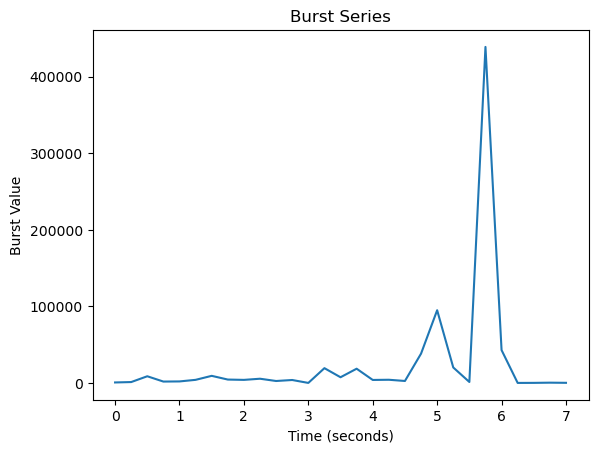

In [16]:

import matplotlib.pyplot as plt
# Plot the burst series
plt.plot(aggregated_bursts.index.total_seconds(), aggregated_bursts.values)
plt.xlabel('Time (seconds)')
plt.ylabel('Burst Value')
plt.title('Burst Series')
plt.show()
